In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split ,GridSearchCV
from sklearn.preprocessing import  MinMaxScaler
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score, classification_report
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from xgboost import plot_importance
from matplotlib import pyplot
from sklearn.feature_selection import SelectFromModel
from numpy import sort, linspace
from AFM_logic import  AFM
from AFM_preprocess import SingleFeat
import catboost
from matplotlib import pyplot as plt
import hashlib
import tensorflow as tf

In [2]:
data_train=pd.read_csv('./data/pred_1.5_take4_train.csv')
data_test=pd.read_csv('./data/pred_1.5_take4_test.csv')

In [3]:
data_train['site_key']=data_train['article_id'].apply(lambda x: str(x).split('_')[0])
data_test['site_key']=data_test['article_id'].apply(lambda x: str(x).split('_')[0])

In [4]:
data_train.columns

Index(['article_id', 'user_id', 'query_params', 'geo_location',
       'traffic_source', 'device', 'browser', 'browser_type', 'screen_length',
       'is_refreshed', 'is_saas', 'is_lazy_loaded', 'is_dcs', 'provider',
       'fold', 'attempt_index', 'position_type', 'browsi_avg_time_in_view',
       'user_velocity_avg', 'user_velocity_static', 'pav', 'bav',
       'avg_user_latency', 'viewability_per_article_and_ad_index', 'is_viewed',
       'site_key'],
      dtype='object')

In [5]:
features={'numeric':  ['fold', 'attempt_index',  'screen_length', 'viewability_per_article_and_ad_index', 
                       'is_refreshed', 'is_lazy_loaded', 'is_saas',
                      'is_dcs'],
         'nominal': {'article_id': 10**4, 'user_id': 2*10**4, 'geo_location': 10**2, 'position_type': 3,
                     'device': 10**2, 'browser': 10**1,'browser_type':2, 'traffic_source':3,'provider': 3, 'query_params': 10**2},
         'user_analytics':['user_velocity_avg', 'user_velocity_static', 'pav', 'bav','avg_user_latency'],
         'target': 'is_viewed'}

In [6]:
def fill_analytics(data, features):
    """ This function fills the missing values in the user_analytics features """
    print('Building Dict')
    aggregation=dict((col, 'mean') for col in features['user_analytics']) #--> {'col1': 'mean', 'col2': 'mean' ..}
    df_grouped=data.groupby('article_id').agg(aggregation) # mean value of each feature per article id
    df_grouped.fillna(df_grouped.mean(),inplace=True)
    mapping_dict=df_grouped.to_dict(orient='index') #--> {'Article 1' : {'feature1': value, 'feature2':value ...}, 'Article 2': {'feature1': value ...}}
    for col in features['user_analytics']: # fill the missing values in the dataframe with values from dict
        print('Filling {}'.format(col))
        data[col]=data.apply(lambda x: mapping_dict[x['article_id']][col] if pd.isnull(x[col]) else x[col],axis=1)
    return data

In [7]:
def preprocess(data, features):
    """ This function fills NAs, encode the nominal features and cap the target """
    cols = []
    target=features['target']
    #mms = MinMaxScaler(feature_range=(0, 1))
    for col in data.columns:
        if col in features['numeric']: # fill na for numeric
            print('Preprocessing Numeric column {}'.format(col))
            data[col].fillna(data[col].mean(), inplace=True)
            cols.append(col)
        elif col in features['nominal'].keys(): # fill na and encode nominal
            print('Preprocessing Nominal column {}'.format(col))
            data[col].fillna("NA_{}".format(col), inplace=True)
            data[col] = data[col].apply(lambda x: int(hashlib.sha1(x.encode('utf-8')).hexdigest(), 16) % (features['nominal'][col]))

            cols.append(col)
        else:
            continue
    print('Preprocessing Analytics features')
    data=fill_analytics(data, features) #  fill na for special case --> user analytics features
    #data[features['numeric']+features['user_analytics']]=mms.fit_transform(data[features['numeric']+features['user_analytics']])
    cols=cols+features['user_analytics']
    return data[cols],data[target], data['site_key']
  

In [8]:
X_train,y_train,_=preprocess(data_train,features)
X_test,y_test,sites_test=preprocess(data_test,features)

Preprocessing Nominal column article_id
Preprocessing Nominal column user_id
Preprocessing Nominal column query_params
Preprocessing Nominal column geo_location
Preprocessing Nominal column traffic_source
Preprocessing Nominal column device
Preprocessing Nominal column browser
Preprocessing Nominal column browser_type
Preprocessing Numeric column screen_length
Preprocessing Numeric column is_refreshed
Preprocessing Numeric column is_saas
Preprocessing Numeric column is_lazy_loaded
Preprocessing Numeric column is_dcs
Preprocessing Nominal column provider
Preprocessing Numeric column fold
Preprocessing Numeric column attempt_index
Preprocessing Nominal column position_type
Preprocessing Numeric column viewability_per_article_and_ad_index
Preprocessing Analytics features
Building Dict
Filling user_velocity_avg
Filling user_velocity_static
Filling pav
Filling bav
Filling avg_user_latency
Preprocessing Nominal column article_id
Preprocessing Nominal column user_id
Preprocessing Nominal colu

In [12]:
X_train.shape, y_train.shape

((1000000, 23), (1000000,))

In [13]:
X_test.shape, y_test.shape

((500000, 23), (500000,))

In [14]:
X_train.isnull().sum(axis=0)

article_id                              0
user_id                                 0
query_params                            0
geo_location                            0
traffic_source                          0
device                                  0
browser                                 0
browser_type                            0
screen_length                           0
is_refreshed                            0
is_saas                                 0
is_lazy_loaded                          0
is_dcs                                  0
provider                                0
fold                                    0
attempt_index                           0
position_type                           0
viewability_per_article_and_ad_index    0
user_velocity_avg                       0
user_velocity_static                    0
pav                                     0
bav                                     0
avg_user_latency                        0
dtype: int64

In [15]:
sparse_features=[ 'article_id', 'query_params',
       'geo_location', 'traffic_source', 'user_id', 'position_type']
dense_features=[ 'is_dcs', 'is_saas', 'is_refreshed', 'is_lazy_loaded']

In [16]:
sparse_feature_list = [SingleFeat(feat, features['nominal'][feat])
                           for feat in sparse_features]
dense_feature_list = [SingleFeat(feat, 0)
                          for feat in dense_features]

In [17]:
print(sparse_feature_list)
print(dense_feature_list)

[SingleFeat(name='article_id', dimension=10000), SingleFeat(name='query_params', dimension=100), SingleFeat(name='geo_location', dimension=100), SingleFeat(name='traffic_source', dimension=3), SingleFeat(name='user_id', dimension=20000), SingleFeat(name='position_type', dimension=3)]
[SingleFeat(name='is_dcs', dimension=0), SingleFeat(name='is_saas', dimension=0), SingleFeat(name='is_refreshed', dimension=0), SingleFeat(name='is_lazy_loaded', dimension=0)]


In [20]:
model = AFM(feature_dim_dict={"sparse": sparse_feature_list,"dense": dense_feature_list},
               l2_reg_linear=0.00002, l2_reg_embedding=0.00005,  final_activation='sigmoid')
model.compile( optimizer='Adam', loss="binary_crossentropy", 
                  metrics=['accuracy'])

In [21]:
train_model_input = [X_train[feat.name].values for feat in sparse_feature_list] + \
        [X_train[feat.name].values for feat in dense_feature_list]
test_model_input = [X_test[feat.name].values for feat in sparse_feature_list] + \
        [X_test[feat.name].values for feat in dense_feature_list]

AFM feature order ['article_id', 'query_params',
                   'geo_location', 'traffic_source', 'user_id',
                   'position_type', 'is_dcs', 'is_saas', 'is_refreshed', 'is_lazy_loaded']

In [22]:
model.fit(train_model_input, y_train.values,
                        batch_size=25600, epochs=20,  validation_split=0.2, )

Train on 800000 samples, validate on 200000 samples
Epoch 1/20
800000/800000 [==============================]800000/800000 [==============================] - 15s 18us/step - loss: 0.7884 - acc: 0.4730 - val_loss: 0.7613 - val_acc: 0.4902

Epoch 2/20
800000/800000 [==============================]800000/800000 [==============================] - 13s 16us/step - loss: 0.7384 - acc: 0.4931 - val_loss: 0.7199 - val_acc: 0.4902

Epoch 3/20
800000/800000 [==============================]800000/800000 [==============================] - 12s 14us/step - loss: 0.7036 - acc: 0.4931 - val_loss: 0.6919 - val_acc: 0.4902

Epoch 4/20
800000/800000 [==============================]800000/800000 [==============================] - 14s 17us/step - loss: 0.6803 - acc: 0.5218 - val_loss: 0.6736 - val_acc: 0.5483

Epoch 5/20
800000/800000 [==============================]800000/800000 [==============================] - 13s 17us/step - loss: 0.6650 - acc: 0.5553 - val_loss: 0.6616 - val_acc: 0.5674

Epoch 6/20
80

In [23]:
y_hat_AM_train = model.predict(train_model_input)


In [24]:
y_hat_AM_test = model.predict(test_model_input)

In [25]:
X_train_catboost=X_train[list(features['nominal'].keys())+features['numeric']+features['user_analytics']]
X_test_catboost=X_test[list(features['nominal'].keys())+features['numeric']+features['user_analytics']]

In [26]:
# Assign predictions from AFM to catboost dataframe
X_train_catboost = X_train_catboost.assign(AFM=y_hat_AM_train.reshape(-1))
X_test_catboost = X_test_catboost.assign(AFM=y_hat_AM_test.reshape(-1))

In [28]:
X_train_catboost.columns

Index(['article_id', 'user_id', 'device', 'traffic_source', 'browser_type',
       'geo_location', 'query_params', 'provider', 'position_type', 'browser',
       'fold', 'attempt_index', 'screen_length',
       'viewability_per_article_and_ad_index', 'is_refreshed',
       'is_lazy_loaded', 'is_saas', 'is_dcs', 'user_velocity_avg',
       'user_velocity_static', 'pav', 'bav', 'avg_user_latency', 'AFM'],
      dtype='object')

In [ ]:
cb = catboost.CatBoostClassifier(eval_metric="Logloss", one_hot_max_size=5, depth=5, iterations= 50, l2_leaf_reg= 0.01, learning_rate= 0.15)#, scale_pos_weight=0.63) 
cb.fit(X_train_catboost,y_train, cat_features= list(range(len(features['nominal'].keys()))))

0:	learn: 0.6617878	total: 1.98s	remaining: 1m 36s
1:	learn: 0.6386821	total: 4.02s	remaining: 1m 36s
2:	learn: 0.6221027	total: 5.91s	remaining: 1m 32s
3:	learn: 0.6095040	total: 7.88s	remaining: 1m 30s
4:	learn: 0.5998605	total: 9.64s	remaining: 1m 26s
5:	learn: 0.5927226	total: 11.4s	remaining: 1m 23s
6:	learn: 0.5873557	total: 13.1s	remaining: 1m 20s
7:	learn: 0.5833734	total: 21.3s	remaining: 1m 51s
8:	learn: 0.5798534	total: 23.5s	remaining: 1m 46s
9:	learn: 0.5774211	total: 25.6s	remaining: 1m 42s
10:	learn: 0.5753377	total: 28.5s	remaining: 1m 41s
11:	learn: 0.5737186	total: 1m 3s	remaining: 3m 20s
12:	learn: 0.5725333	total: 1m 5s	remaining: 3m 5s
13:	learn: 0.5713841	total: 1m 6s	remaining: 2m 51s
14:	learn: 0.5703894	total: 1m 8s	remaining: 2m 40s
15:	learn: 0.5695821	total: 1m 10s	remaining: 2m 30s
16:	learn: 0.5690132	total: 1m 12s	remaining: 2m 21s
17:	learn: 0.5683160	total: 1m 14s	remaining: 2m 12s
18:	learn: 0.5677127	total: 1m 16s	remaining: 2m 4s
19:	learn: 0.5672982

In [348]:
y_hat=cb.predict_proba(X_test_catboost)[:,1]
y_pred=cb.predict(X_test_catboost)

In [365]:
print(log_loss(y_test.values,y_hat))
print(accuracy_score(y_test.values,y_pred))
print(classification_report(y_test.values,y_pred))
print("test AUC", round(roc_auc_score(y_test.values, y_hat), 4))


0.559925227693273
0.711842
              precision    recall  f1-score   support

           0       0.68      0.47      0.56    191050
           1       0.72      0.86      0.79    308950

   micro avg       0.71      0.71      0.71    500000
   macro avg       0.70      0.67      0.67    500000
weighted avg       0.71      0.71      0.70    500000

test AUC 0.7546


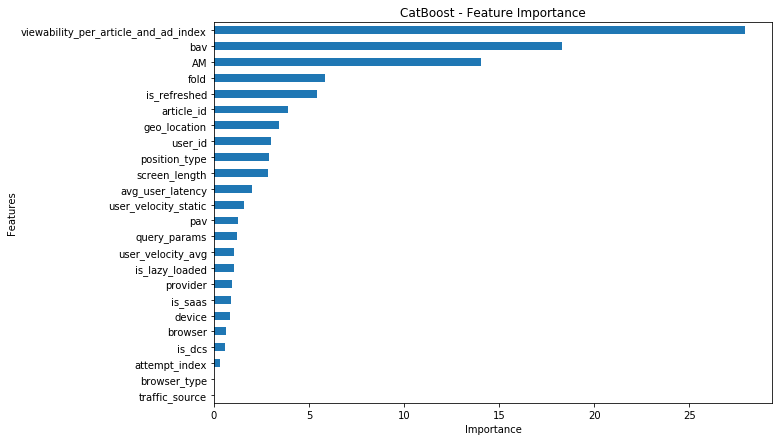

In [350]:
fea_imp = pd.DataFrame({'imp': cb.feature_importances_, 'col': X_train_catboost.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.title('CatBoost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance');

In [366]:
results=pd.DataFrame()
results['site_key']=sites_test
results['y_hat']=y_hat
results['y']=y_test.values

In [367]:
def to_tiers(yhat):
    if yhat>=0 and yhat<0.1:
        return 0
    if yhat>=0.1 and yhat<0.2:
        return 0.1
    if yhat>=0.2 and yhat<0.3:
        return 0.2
    if yhat>=0.3 and yhat<0.4:
        return 0.3
    if yhat>=0.4 and yhat<0.5:
        return 0.4
    if yhat>=0.5 and yhat<0.6:
        return 0.5
    if yhat>=0.6 and yhat<0.7:
        return 0.6
    if yhat>=0.7 and yhat<0.8:
        return 0.7
    if yhat>=0.8 and yhat<0.9:
        return 0.8
    return 0.9

In [368]:
def results_by_site(df):
    df['tier'] = df.apply(lambda row: to_tiers(row['y_hat']), axis=1)
    results_grouped = df.groupby(['site_key','tier']).agg({'y_hat': 'count', 'y': 'sum'}).reset_index().rename(
        columns={'y_hat': 'imps', 'y': 'viewed_imps'})
    results_grouped['viewability'] = results_grouped['viewed_imps'] / results_grouped['imps']
    print(results_grouped)
    return results_grouped

In [369]:
def results_(df):
    df['tier'] = df.apply(lambda row: to_tiers(row['y_hat']), axis=1)
    results_grouped = df.groupby(['tier']).agg({'y_hat': 'count', 'y': 'sum'}).reset_index().rename(
        columns={'y_hat': 'imps', 'y': 'viewed_imps'})
    results_grouped['viewability'] = results_grouped['viewed_imps'] / results_grouped['imps']
    print(results_grouped)
    return results_grouped

In [370]:
r=results_(results)

   tier   imps  viewed_imps  viewability
0   0.0  12568          636     0.050605
1   0.1  14718         2170     0.147439
2   0.2  21313         5377     0.252287
3   0.3  34050        12145     0.356681
4   0.4  50318        22670     0.450535
5   0.5  68690        37795     0.550226
6   0.6  83028        53926     0.649492
7   0.7  95975        72013     0.750331
8   0.8  94549        79419     0.839977
9   0.9  24791        22799     0.919648


In [371]:
r_site=results_by_site(results)

                  site_key  tier   imps  viewed_imps  viewability
0                     12up   0.0     28            2     0.071429
1                     12up   0.1    137           25     0.182482
2                     12up   0.2    329           63     0.191489
3                     12up   0.3    648          216     0.333333
4                     12up   0.4    863          371     0.429896
5                     12up   0.5   1531          814     0.531679
6                     12up   0.6   2529         1617     0.639383
7                     12up   0.7   2973         2284     0.768248
8                     12up   0.8   3320         2849     0.858133
9                     12up   0.9    594          548     0.922559
10                   90min   0.0    494           25     0.050607
11                   90min   0.1   1340          214     0.159701
12                   90min   0.2   2422          643     0.265483
13                   90min   0.3   3804         1391     0.365668
14        

In [61]:
r.to_csv('/home/alon/Downloads/results_by_site.csv', index=False)

In [ ]:
r.to_csv('/home/alon/Downloads/results_by_site.csv', index=False)